### Compute correlation coefficient between MODIS chlorophyll and SMYLE FOSI chlorophyll

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import cmocean

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd
import utils
style.use('default')
import matplotlib.path as mpath

### Get MODIS chlorophyll data cumulative mean

In [2]:
path = '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_'
files = []

files.extend(sorted(glob(f'{path}*.nc')))
#files

In [3]:
len(files)

294

In [4]:
files[4:100]

['/glade/work/kristenk/satellite_data/globcolour_chl/L3m_19980101-19980131__GLOB_25_GSM-SWF_CHL1_MO_00.nc',
 '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_19980201-19980228__GLOB_25_GSM-SWF_CHL1_MO_00.nc',
 '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_19980301-19980331__GLOB_25_GSM-SWF_CHL1_MO_00.nc',
 '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_19980401-19980430__GLOB_25_GSM-SWF_CHL1_MO_00.nc',
 '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_19980501-19980531__GLOB_25_GSM-SWF_CHL1_MO_00.nc',
 '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_19980601-19980630__GLOB_25_GSM-SWF_CHL1_MO_00.nc',
 '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_19980701-19980731__GLOB_25_GSM-SWF_CHL1_MO_00.nc',
 '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_19980801-19980831__GLOB_25_GSM-SWF_CHL1_MO_00.nc',
 '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_19980901-19980930__GLOB_25_GSM-SWF_CHL1_MO_00.nc',
 '/glade/work/kristenk/satel

In [5]:
files = files[4:100]

In [6]:
ds=xr.open_mfdataset(files,concat_dim='time',combine='nested')

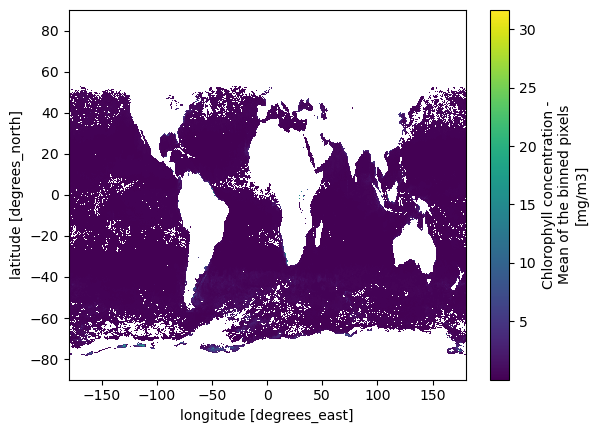

In [7]:
ds.CHL1_mean.isel(time=0).plot()

In [8]:
ds = ds.mean(dim='time')

In [9]:
ds.CHL1_mean

<xarray.DataArray 'CHL1_mean' (lat: 720, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(720, 1440), dtype=float32, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    standard_name:            mass_concentration_of_chlorophyll_a_in_sea_water
    long_name:                Chlorophyll concentration - Mean of the binned ...
    units:                    mg/m3
    pct_characterised_error:  43.31

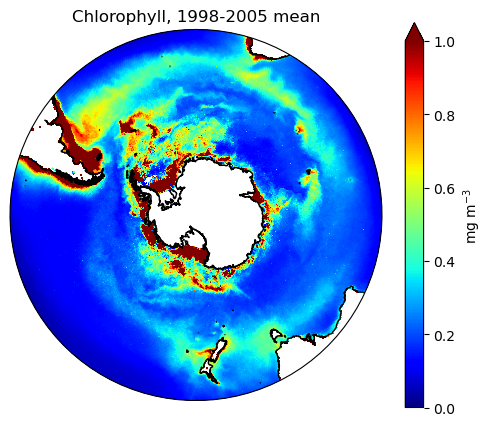

In [10]:
fig = plt.figure(figsize=(6,5))

########################################################################### modis chlorophyll
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())

ax.set_title('Chlorophyll, 1998-2005 mean')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=1)
pc=ax.pcolormesh(ds.lon, ds.lat, ds.CHL1_mean, 
                 vmin=0, vmax=1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())



cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mg m$^{-3}$');
#fig.savefig('/glade/work/kristenk/figs/chl_comparison.png', bbox_inches='tight', dpi=300, format='png');

In [11]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
area = ds_grid.TAREA

In [12]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Chl_surf']

ds_list = []
ds2 = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds2 = xr.merge((ds2, dsv))
    ds_list.append(ds2)

Chl_surf
CPU times: user 10.7 ms, sys: 98 µs, total: 10.8 ms
Wall time: 70.6 ms


In [13]:
ds2.time[78:86]

<xarray.DataArray 'time' (time: 8)>
array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005])
Coordinates:
  * time     (time) int64 1998 1999 2000 2001 2002 2003 2004 2005

In [14]:
ds2 = ds2.isel(time=slice(78,86)).mean(dim='time')

In [15]:
ds2 = ds2.mean(dim='member_id')

In [16]:
ds2 = ds2.where(ds_grid.REGION_MASK >0)

In [17]:
import matplotlib.colors as colors

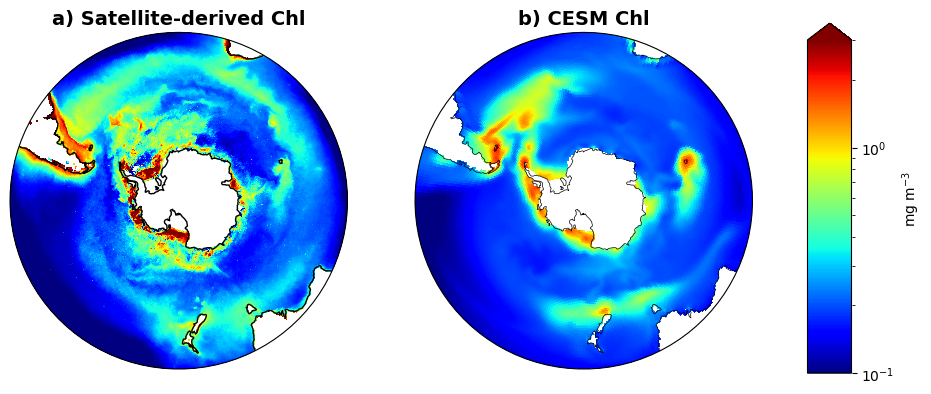

In [18]:
fig = plt.figure(figsize=(11,5))

ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) Satellite-derived Chl',fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
# make it a circle
ax.set_boundary(circle, transform=ax.transAxes)


ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(ds.lon, ds.lat, ds.CHL1_mean, 
                 norm=colors.LogNorm(vmin=0.1, vmax=3),
                 #vmin=0, vmax=1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())



ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) CESM Chl',fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
# make it a circle
ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats,(ds2.Chl_surf))
pc=ax.pcolormesh(lon, lat, 
                 field, 
                 norm=colors.LogNorm(vmin=0.1, vmax=3),
                 #vmin=0, vmax=2, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
# cbar1 = fig.colorbar(pc, ax=ax,extend='max')
# cbar1.set_label(label='(mmol m$^{-2}$ d$^{-1}$)',size=14)
# cbar1.ax.tick_params(labelsize=14)



fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.04, 0.7])
#cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='mg m$^{-3}$');



#fig.savefig('/glade/work/kristenk/figs/change_in_Fe_mean_150m.png', bbox_inches='tight', dpi=300, format='png');

### get seasonal cycle of chlorophyll from CESM over the same period

In [19]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Chl_surf']

ds_list = []
ds_cesm_mon = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_monthly_1998to2005.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_cesm_mon = xr.merge((ds_cesm_mon, dsv))
    ds_list.append(ds_cesm_mon)

Chl_surf
CPU times: user 18.2 ms, sys: 0 ns, total: 18.2 ms
Wall time: 73.8 ms


### make monthly clim

In [20]:
ds_cesm_mon = ds_cesm_mon.groupby('time.month').mean('time')

In [21]:
ds_cesm_mon

<xarray.Dataset>
Dimensions:    (member_id: 34, month: 12, nlat: 384, nlon: 320, z_t: 60)
Coordinates:
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT        (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA      (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz         (month, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    Chl_surf   (month, member_id, nlat, nlon) float32 dask.array<chunksize=(1, 34, 384, 320), meta=np.ndarray>

### Get the masks

In [22]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1920s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

In [23]:
ts_ACC = xr.Dataset({v: ds_cesm_mon[v] for v in ['month']})
ts_SIZ = xr.Dataset({v: ds_cesm_mon[v] for v in ['month']})

for var in variables:
    masked = ds_cesm_mon[var].where(ds_masks.ACC_mask==1.)
    ts_ACC[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds_cesm_mon[var].where(ds_masks.SIZ_mask ==1.)
    ts_SIZ[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
ts_ACC = xr.concat([ts_ACC,ts_ACC.isel(month=slice(0,6))],dim='month')
ts_SIZ = xr.concat([ts_SIZ,ts_SIZ.isel(month=slice(0,6))],dim='month')

In [24]:
xvals = [7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,18]
xlabels = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']

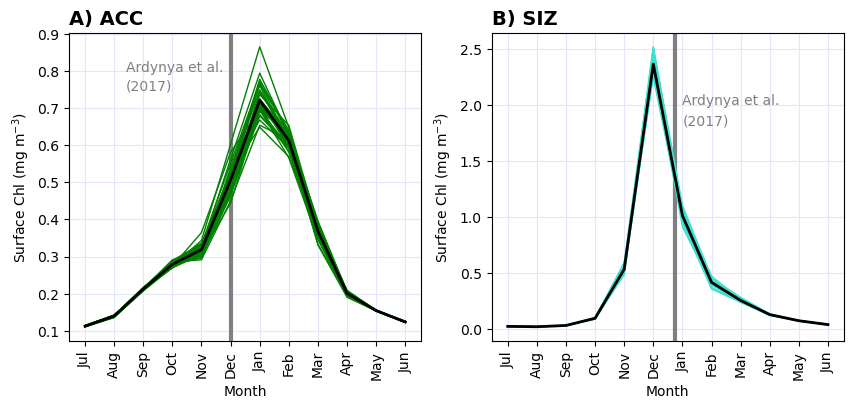

In [25]:
fig = plt.figure(figsize=(10,4))


######################################################## ACC

ax1 = fig.add_subplot(1,2,1)
ax1.set_title('A) ACC ',fontsize=14,fontweight='bold',loc='left')
ax1.set_ylabel('Surface Chl (mg m$^{-3}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(20,168)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.axvline(x=12,color='gray',linestyle='-',linewidth=3)
ax1.text(8.4,0.8,'Ardynya et al.',color='gray')
ax1.text(8.4,0.75,'(2017)',color='gray')


ax1.plot(xvals,ts_ACC['Chl_surf'].isel(month=slice(6,18)), 
         color='green', label='chl', lw=1)
ax1.plot(xvals,ts_ACC['Chl_surf'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='black', label='chl', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical');

######################################################## ACC

ax1 = fig.add_subplot(1,2,2)
ax1.set_title('B) SIZ ',fontsize=14,fontweight='bold',loc='left')
ax1.set_ylabel('Surface Chl (mg m$^{-3}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(20,168)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

ax1.axvline(x=12.75,color='gray',linestyle='-',linewidth=3)
ax1.text(13,2,'Ardynya et al.',color='gray')
ax1.text(13,1.82,'(2017)',color='gray')

#plot 1920s
ax1.plot(xvals,ts_SIZ['Chl_surf'].isel(month=slice(6,18)), 
         color='turquoise', label='chl', lw=1)

ax1.plot(xvals,ts_SIZ['Chl_surf'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='black', label='chl', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical');

### Now combine the maps and the line plots

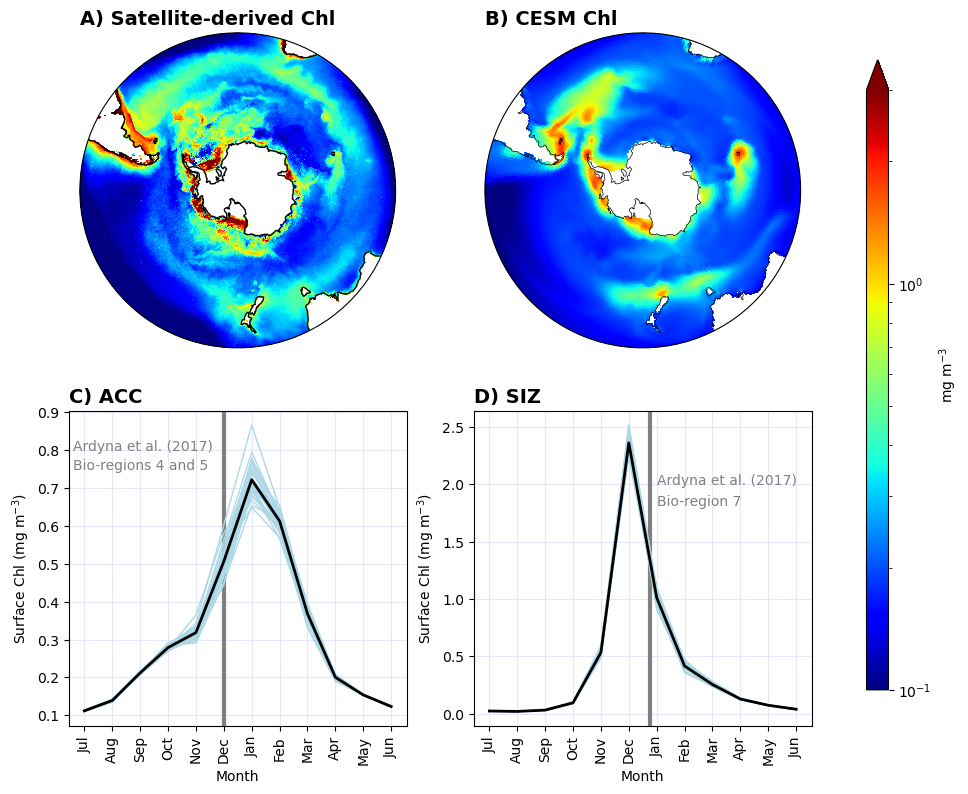

In [26]:
fig = plt.figure(figsize=(11,9))

############## map of sat chl
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('A) Satellite-derived Chl',fontsize=14, fontweight='bold',loc='left')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
# make it a circle
ax.set_boundary(circle, transform=ax.transAxes)

ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(ds.lon, ds.lat, ds.CHL1_mean, 
                 norm=colors.LogNorm(vmin=0.1, vmax=3),
                 #vmin=0, vmax=1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

############## map of CESM chl
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('B) CESM Chl',fontsize=14, fontweight='bold',loc='left')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
# make it a circle
ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = utils.adjust_pop_grid(lons, lats,(ds2.Chl_surf))
pc=ax.pcolormesh(lon, lat, 
                 field, 
                 norm=colors.LogNorm(vmin=0.1, vmax=3),
                 #vmin=0, vmax=2, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

######## map color bar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='mg m$^{-3}$');

#################################### line plots

##############ACC

ax1 = fig.add_subplot(2,2,3)
ax1.set_title('C) ACC ',fontsize=14,fontweight='bold',loc='left')
ax1.set_ylabel('Surface Chl (mg m$^{-3}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(20,168)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.axvline(x=12,color='gray',linestyle='-',linewidth=3)
ax1.text(6.6,0.8,'Ardyna et al. (2017)',color='gray')
ax1.text(6.6,0.75,'Bio-regions 4 and 5',color='gray')


ax1.plot(xvals,ts_ACC['Chl_surf'].isel(month=slice(6,18)), 
         color='lightblue', label='chl', lw=1)
ax1.plot(xvals,ts_ACC['Chl_surf'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='black', label='chl', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical');

############# SIZ

ax1 = fig.add_subplot(2,2,4)
ax1.set_title('D) SIZ ',fontsize=14,fontweight='bold',loc='left')
ax1.set_ylabel('Surface Chl (mg m$^{-3}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(20,168)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

ax1.axvline(x=12.75,color='gray',linestyle='-',linewidth=3)
ax1.text(13,2,'Ardyna et al. (2017)',color='gray')
ax1.text(13,1.82,'Bio-region 7',color='gray')

#plot 1920s
ax1.plot(xvals,ts_SIZ['Chl_surf'].isel(month=slice(6,18)), 
         color='lightblue', label='chl', lw=1)

ax1.plot(xvals,ts_SIZ['Chl_surf'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='black', label='chl', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical');

fig.savefig('/glade/work/kristenk/figs/cesm1le_chl_comparison.png', bbox_inches='tight', dpi=300, format='png');